In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ansim_dataset_unconf import ansimDataset, create_circular_mask, ansimDataset_orientation
from ConvLSTM_unconf import MtConvLSTM
import random
import math
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import os
import scipy.ndimage
import cv2
import scipy.misc
from array2gif import write_gif
from scipy.misc import imsave

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
img_path = '/home/rliu/ansim/data/unconfined_steph/cropped_orientation/'
img_list_csv = '/home/rliu/github/ansim/unconfined_orientation/img_list.csv'
train_csv = '/home/rliu/github/ansim/unconfined_orientation/train_unconf.csv'
test_csv = '/home/rliu/github/ansim/unconfined_orientation/test_unconf.csv'
output_path = '/home/rliu/ansim/models/dataset3/6-17_mt_paper_orientation/final.weights'

In [4]:
mask = create_circular_mask(128,128)
testset = ansimDataset_orientation(img_list_csv = img_list_csv, seq_csv = test_csv, root_dir = img_path, step=10, random_rotate = False, transform=None, image_size = 128, rand_range=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False,
                                                     num_workers=1)

In [5]:
model = torch.load('/home/rliu/ansim/models/dataset3/6-19_mt_paper_orientation/0220.weights')
model = model.module

/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the 

In [6]:
dataiter = iter(testloader)
for i in range(6):
    images = dataiter.next()
    data_split = torch.split(images, (5,5), dim=1)
    inputs_t = data_split[0]
    target_t = data_split[1]
    inputs_t, target_t = inputs_t.cuda(), target_t.cuda()
_, _, _, predicted_t = model(inputs_t)

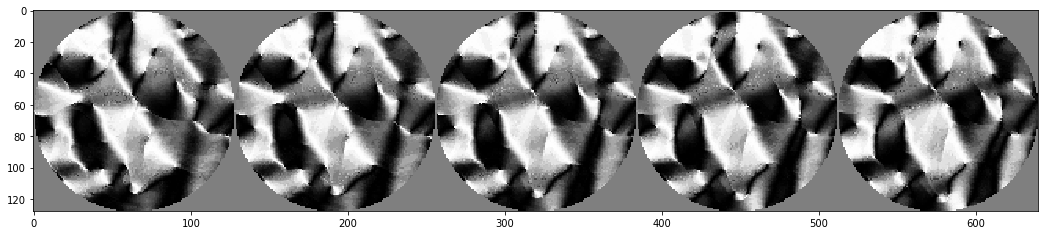

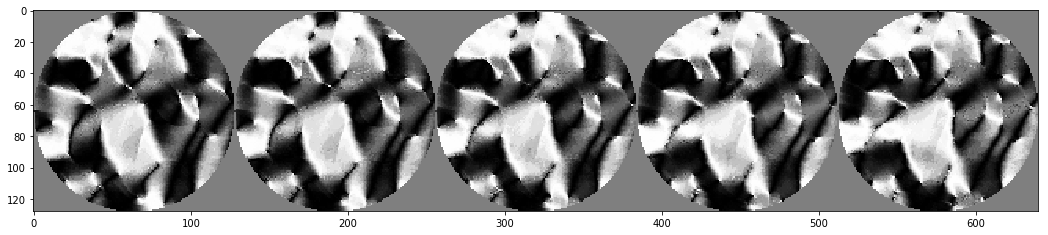

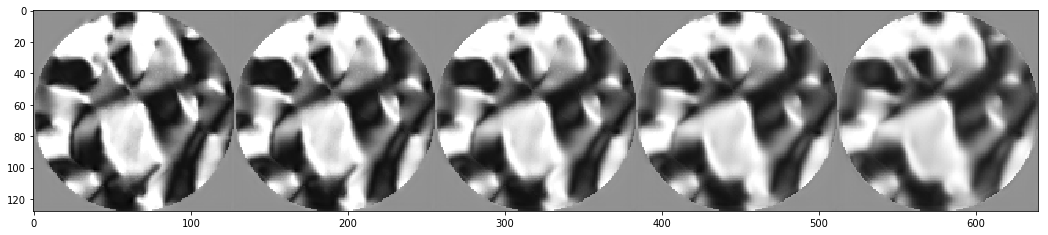

In [7]:
inputs = inputs_t[0,:,1,:,:].cpu().detach().numpy()
target = target_t[0,:,1,:,:].cpu().detach().numpy()
predicted = predicted_t[0,:,1,:,:].cpu().detach().numpy()

inputs = (inputs + 0.5) * 255
target = (target + 0.5) * 255
predicted = (predicted + 0.5) * 255

inputs = inputs.reshape(640,128).transpose().astype(int)
target = target.reshape(640,128).transpose().astype(int)
predicted = predicted.reshape(640,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

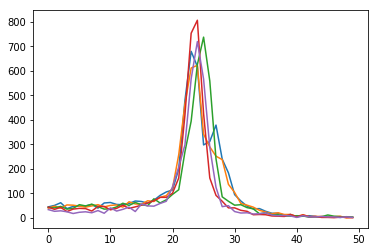

In [43]:
im_1 = predicted_t.cpu().detach().numpy()[0,0,0,:,:] * 255
histg1 = cv2.calcHist([im_1],[0],None,[50],[115,140])
plt.plot(histg1)
im_2 = predicted_t.cpu().detach().numpy()[0,1,0,:,:] * 255
histg2 = cv2.calcHist([im_2],[0],None,[50],[115,140])
plt.plot(histg2)
im_3 = predicted_t.cpu().detach().numpy()[0,2,0,:,:] * 255
histg3 = cv2.calcHist([im_3],[0],None,[50],[115,140])
plt.plot(histg3)
im_4 = predicted_t.cpu().detach().numpy()[0,3,0,:,:] * 255
histg4 = cv2.calcHist([im_4],[0],None,[50],[115,140])
plt.plot(histg4)
im_5 = predicted_t.cpu().detach().numpy()[0,4,0,:,:] * 255
histg5 = cv2.calcHist([im_5],[0],None,[50],[115,140])
plt.plot(histg5)
plt.show()

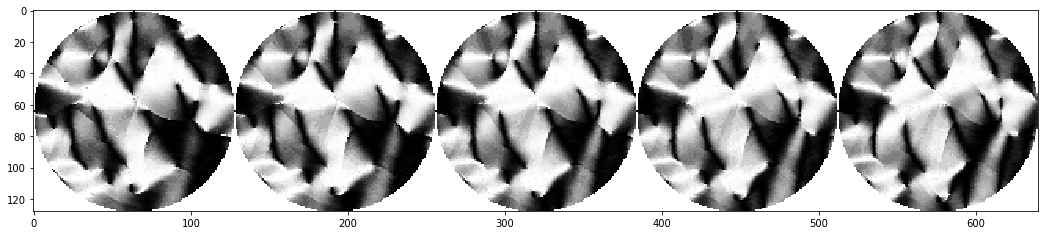

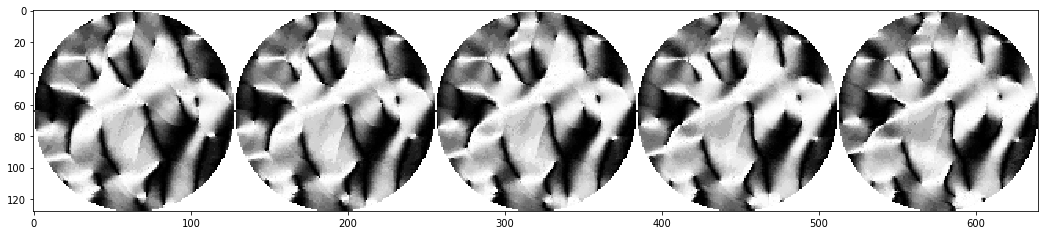

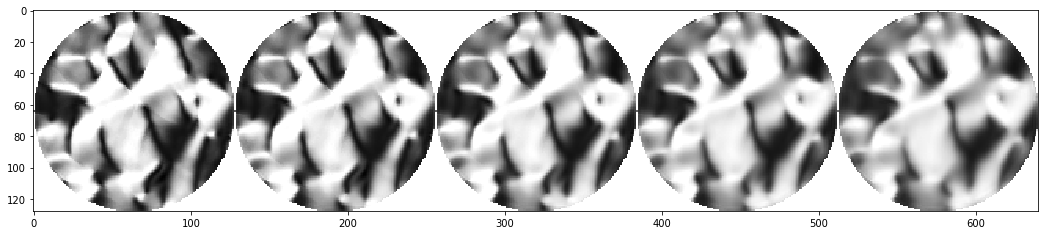

In [44]:
predicted = predicted_t[0,:,0,:,:].cpu().detach().numpy()
target = target_t[0,:,0,:,:].cpu().detach().numpy()
inputs = inputs_t[0,:,0,:,:].cpu().detach().numpy()

inputs = (inputs + 0.5) * 255
target = (target + 0.5) * 255
predicted = (predicted + 0.5) * 255

inputs = inputs.reshape(640,128).transpose().astype(int)
target = target.reshape(640,128).transpose().astype(int)
predicted = predicted.reshape(640,128).transpose().astype(int)

inputs = inputs - inputs.min()
target = target - target.min()
predicted = predicted - predicted.min()

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(inputs, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(target, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
ax.imshow(predicted, interpolation='nearest', cmap='gray', vmin=0, vmax=255)

In [26]:
a = Image.open('/home/rliu/ansim/data/unconfined_steph/cropped_orientation/000001.jpg')
image_resized = torchvision.transforms.functional.resize(a, (128,128), interpolation=Image.NEAREST)
image_resized = np.array(image_resized)
image_resized = image_resized / 255 * math.pi
image_qxx = np.power(np.cos(image_resized),2) - 1/2
image_qxy = np.cos(image_resized) * np.sin(image_resized)
image_tensor_qxx = torch.from_numpy(image_qxx)
image_tensor_qxy = torch.from_numpy(image_qxy)

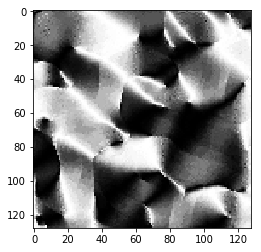

In [28]:
plt.imshow(image_tensor_qxy,cmap='gray')

In [5]:
image_qxx = np.power(np.cos(a),2) - 1/2
image_qxy = np.cos(a) * np.sin(a)
# image_tensor_qxx = torch.from_numpy(image_qxx)
# image_tensor_qxy = torch.from_numpy(image_qxy)

In [6]:
plt.imshow(image_qxx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f459afd3f28> (for post_execute):


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

<Figure size 432x288 with 1 Axes>